In [19]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency, norm, ttest_ind, f_oneway # Pruebas de hipótesis y análisis estadístico
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix,roc_curve, auc

import warnings
warnings.filterwarnings("ignore")#ignorar advertencias


#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

# **Encuesta Financiera de las Familias (EFF) - España, 2022**

*Libro de código extraído directamente del Banco de España*

> https://app.bde.es/efs_www/codes?lang=ES

### Descarga y preparación de los datos
Para empezar a trabajar con los microdatos de la EFF primero debemos descargarlos de la sección Microdatos y los guardaremos en la carpeta que queramos del explorador de archivos.

Para replicar los resultados del Artículo Analítico (AA) correspondiente a la EFF2022 utilizaremos las bases databol.dta en la que ya están creadas las variables que se muestran en los cuadros del AA (consultar el documento “definiciones” para ver cómo se construyen las variables del AA partiendo de las preguntas del cuestionario).

Para crear la base de datos, debemos unir las 5 imputaciones, y crear un indicador (variable implicate) que identifique cada una.

In [20]:
# load the data creating the imputation indicator, using the correct separator
df_eff = pd.concat(
    [pd.read_csv(
        r"..\Data\EFF2022\databol_2022_csv\databol{}.csv".format(i),
        sep=";"
    ).assign(imputation=i) for i in range(1, 6)]
)

# replace the values for legibility
replace_dict = {
    "bage": {
        1: "Under 35", 2: "35-44", 3: "45-54", 4: "55-64", 5: "65-74", 6: "Over 75"
    },
    "percrent": {
        1: "< P20", 2: "P20-P40", 3: "P40-P60", 4: "P60-80", 5: "P80-P90", 6: "> P90"
    },
    "nsitlabdom": {
        1: "Employee", 2: "Self-Employed", 3: "Retired", 4: "Other Inactive or Unemployed"
    },
    "neducdom": {
        1: "Below Secondary Education", 2: "Secondary Education", 3: "University Education"
    },
    "np2_1": {
        1: "Ownership", 2: "Other"
    },
    "nnumadtrab": {
        0: "None", 1: "One", 2: "Two", 3: "Three or More"
    },
    "np1": {
        5: "5 or more"
    },
    "percriq": {
        1: "< P25", 2: "P25-P50", 3: "P50-P75", 4: "P75-P90", 5: "> P90"
    }
}
df_eff["np1"] = df_eff["np1"].astype(int)
df_eff = df_eff.replace(to_replace=replace_dict)

In [21]:
df_eff.head(5)

,h_2022,facine3,p2_69,p2_84,p2_70,p2_71,p4_7_3,p4_15,p4_24,p4_35,...,riquezanet,percriq,pagodeuda,alim,nodur,gvehic,gimpvehic,tvehic,timpvehic,imputation
0,1,2956.913200,1,100000.0,1000.0,500000,7000.0,15000.0,NaN,10000.0,...,1350530.0,> P90,0,14400.0,13212.0,0,0,1,6500,1
1,2,50.462724,2,30000.0,NaN,90000,125000.0,600000.0,NaN,75000.0,...,3805000.0,> P90,0,7200.0,15600.0,0,0,1,30000,1
2,3,67.518567,1,30000.0,5000.0,40000,24000.0,NaN,NaN,NaN,...,3414000.0,> P90,0,9600.0,38400.0,0,0,1,20000,1
3,4,7216.692200,1,NaN,600.0,8000,17000.0,NaN,NaN,NaN,...,158471.0,P50-P75,47,10800.0,7200.0,1,10000,1,21000,1
4,5,3696.269000,2,NaN,NaN,6000,240.0,NaN,NaN,NaN,...,177538.5,P50-P75,150,1200.0,1368.0,1,120,1,580,1


In [22]:
# Guardo el CSV en EFF2022
df_eff.to_csv('../data/EFF2022/df_eff.csv', index=False)

### Cálculo de estadísticos con pesos e imputaciones
- ##### Medias y medianas para el total de hogares
Esta sección muestra cómo calcular medias, proporciones y medianas con la EFF. En concreto, se replican los resultados del Cuadro 1A del AA, que muestra la media y la mediana de la renta de los hogares (renthog21_eur22)

Hay que tener en cuenta que el diseño estratificado con sobrerrepresentación del nivel de riqueza de la muestra hace que sea necesario utilizar los pesos (variable facine3) para el cálculo de estadísticos descriptivos.

Además, para estimar estadísticos de posición (como lo son la media o la mediana u otros percentiles de la distribución) utilizando las 5 imputaciones:
-   Primero debemos calcular el estadístico deseado por separado en cada una de las 5 imputaciones.
-   Posteriormente debemos calcular la media simple de las 5 estimaciones:

In [23]:
# # create a function to calcualte the weighted median
# def weighted_median(variable, weights):
#     variable = variable.values
#     weights = weights.values
#     sorted_idx = np.argsort(variable)
#     cum_weights = np.cumsum(weights[sorted_idx])
#     lower_percentile_idx = np.searchsorted(
#         cum_weights, 0.5 * cum_weights[-1]
#     )
#     return variable[sorted_idx[lower_percentile_idx]]

# # use a group by operation to calculate the weighted statistic for each implicate, 
# # and then average over the 5 implicates

# mean_renthog = df_eff.groupby('imputation').apply(lambda x: np.average(
#     x['renthog21_eur22'], weights=x['facine3'])).mean()
# print("Mean: {:.2f}".format(mean_renthog))
# median_renthog = df_eff.groupby('imputation').apply(lambda x: weighted_median(
#     variable=x['renthog21_eur22'], weights=x['facine3'])).mean()
# print("Median: {:.2f}".format(median_renthog))

- ##### Medias y medianas por subgrupos de población
Adicionalmente, es interesante conocer la media y mediana de la renta de los hogares por grupos poblacionales. Para calcularlo, debemos dividir la muestra en los subgrupos poblacionales para los que queramos hacer las estimaciones, y seguir los dos pasos previos (1. Estimación en cada imputación y 2. Media simple de las 5 estimaciones).

Comenzamos con una muestra de cómo calcular la media y mediana de la renta de los hogares (renthog21_eur22) por edad del cabeza de familia(bage)

In [24]:
# # use a group by operation to calculate the weighted statistic for each implicate and breakdown category, 
# # and then average over the 5 implicates

# mean_renthog = df_eff.groupby(['imputation', 'bage']).apply(lambda x: np.average(
#     x['renthog21_eur22'], weights=x['facine3'])).reset_index().pivot(values=0, columns='bage', index='imputation').mean(0)
# print("Mean income by household head age:", mean_renthog)
# median_renthog = df_eff.groupby(['imputation', 'bage']).apply(lambda x:  weighted_median(
#     variable=x['renthog21_eur22'], weights=x['facine3'])).reset_index().pivot(values=0, columns='bage', index='imputation').mean(0)
# print("Median income by household head age:", median_renthog)

- ##### Proporciones
Un cálculo adicional que aparece en el Cuadro 1.A es el porcentaje de hogares que forman parte de cada uno de los grupos de edad. Una proporción puede estimarse como la media de una variable binaria que tome valor 1 si una observación forma parte de dicho subgrupo, y 0 si no forma parte. Por lo tanto, podemos calcular proporciones construyendo variables binarias y replicando los pasos anteriores para el cálculo de la media.

In [25]:
# prop = df_eff.groupby(['imputation', 'bage'])["facine3"].sum().reset_index().pivot(
#     values="facine3", index='imputation', columns='bage').mean(0)
# prop = (prop / prop.sum()) * 100
# print("Proportion of households by household head age:", prop)

- ##### Réplica del cuadro 1A del AA
Juntando todo lo anterior, el siguiente código replica el cuadro 1A del AA, calculando la proporción de hogares en cada subgrupo poblacional, y la la media y mediana de la renta para todos los hogares y todos los subgrupos que se consideran en del artículo analítico:

In [26]:
# groups = list(replace_dict.keys())
# groups.extend([None])

# # let's create a function to parametrise the calculation of any given variable statistic

# def get_group_statistics(variable, group_name):

#     # variable: str
#     #   indicates the name of the variable. i.e.: "riquezanet"
#     # group_name: str
#     #   indicates the name of the breakdown. i.e.: "bage"

#     if group_name is not None:
#         mean_var = df_eff.groupby(['imputation', group_name]).apply(lambda x: np.average(
#             x[variable], weights=x['facine3'])).reset_index().pivot(
#             values=0, columns=group_name, index='imputation').mean(0).rename("Mean")
#         median_var = df_eff.groupby(['imputation', group_name]).apply(lambda x: weighted_median(
#             variable=x[variable], weights=x['facine3'])).reset_index().pivot(values=0, columns=group_name,
#                                                                              index='imputation').mean(0).rename("Median")
#         prop_var = df_eff.groupby(['imputation', group_name])["facine3"].sum().reset_index().pivot(
#             values="facine3", index='imputation', columns=group_name).mean(0)
#         prop_var = (prop_var / prop_var.sum()) * 100
#         prop_var = prop_var.rename("Proportion")

#         df = pd.concat([mean_var, median_var, prop_var], axis=1).stack().reset_index()
#         df.columns = ['category', "statistic", "value"]
#         df['variable'] = variable
#         df['group'] = group_name
#     else:
#         mean_var = df_eff.groupby('imputation').apply(lambda x: np.average(
#             x[variable], weights=x['facine3'])).mean()
#         median_var = df_eff.groupby('imputation').apply(lambda x: weighted_median(
#             variable=x[variable], weights=x['facine3'])).mean()
#         prop = 100
#         df = pd.DataFrame({
#             "category": "All Households",
#             "statistic": ["Mean", "Median", "Proportion"],
#             "value": [mean_var, median_var, prop],
#             "variable": "All Households",
#             "group": "All Households"
#         })

#     return df


# table_1A = [get_group_statistics("renthog21_eur22", group) for group in groups]
# table_1A = pd.concat(table_1A)

---

## **Información relevante**

EFF contiene información detallada de la situación financiera de los hogares españoles, incluyendo renta, activos (reales y financieros), deudas y gastos.
- Composición de patrimonio (vivienda, acciones, negocios…)
- Tenencia y valor de activos/deudas
- Ingresos (laborales y no laborales)
- Endeudamiento y carga financiera
- Comportamientos financieros (por edad, educación, renta…)

#### Categorías incluidas:
- Personas/hogares. No incluye empresas ni servicios.

#### Variables:
- renthog: renta bruta total del hogar (anual)
- riquezanet: riqueza neta (activos - deudas)
- Variables de tenencia y valor de activos reales (p.ej., np2_1 para vivienda principal)
- Variables sobre cuentas, depósitos, fondos, seguros y deudas (np4_5, np5_1, etc.)

#### Tipo de variables:
- Numéricas (valores de renta, deuda, activos)
- Categóricas (situación laboral, educación)
- Binarias (tenencia de activos)

#### Agrupaciones:
Por edad, nivel educativo, situación laboral del cabeza de hogar, nivel de renta, tamaño del hogar, régimen de tenencia de la vivienda, etc.

#### Limitaciones:
- Imputación de datos faltantes:
Existen 5 datasets imputados (datos corregidos por no respuesta). La variable shadow indica el nivel de imputación aplicado.
- Sobreestimación de hogares ricos:
Hay sobremuestreo de hogares con mayor riqueza (para estudiar los extremos de la distribución).
- Cambios metodológicos menores entre olas:
Aunque consistentes, algunas definiciones o pesos cambian ligeramente. Se debe revisar la documentación antes de comparar ediciones.
- No incluye microdatos de localización exacta por privacidad.

---

#### Renombrar columnas

In [27]:
print(len(df_eff.columns))
df_eff.columns

78


Index(['h_2022', 'facine3', 'p2_69', 'p2_84', 'p2_70', 'p2_71', 'p4_7_3',
       'p4_15', 'p4_24', 'p4_35', 'p4_43', 'np1', 'np2_1', 'np2_32', 'np2_82',
       'np2_5', 'np2_8', 'np4_5', 'np4_10', 'np4_18', 'np4_33', 'np4_27',
       'np5_1', 'renthog21_eur22', 'percrent', 'bage', 'nsitlabdom',
       'neducdom', 'nnumadtrab', 'haveneg', 'havenegval', 'tienereal',
       'cuentas', 'seguro', 'penseg', 'cart_gest', 'valdeuhog', 'havedeuhog',
       'sideuda', 'tienefin', 'tiene', 'otraspr', 'valhog', 'allf',
       'salcuentas', 'valor', 'valseg', 'valpenseg', 'odeuhog', 'dvivpral',
       'dpdte', 'deuoprop', 'dpdtehipo', 'deuhipv', 'hipo', 'phipo', 'perso',
       'pperso', 'deuda_tarj', 'ptmos_tarj', 'otrasd', 'potrasd', 'adeuda',
       'vdeuda', 'deuotros', 'actreales', 'actfinanc', 'riquezabr',
       'riquezanet', 'percriq', 'pagodeuda', 'alim', 'nodur', 'gvehic',
       'gimpvehic', 'tvehic', 'timpvehic', 'imputation'],
      dtype='object')

In [28]:
# Diccionario de renombramiento corregido
column_dict = {
    'h_2022': 'id_hogar',
    'facine3': 'factor_expansion',
    'p2_69': 'adquiere_bien_duradero',
    'p2_84': 'valor_joyas_arte',
    'p2_70': 'gasto_bienes_duraderos',
    'p2_71': 'valor_bienes_duraderos',
    'p4_7_3': 'saldo_cuentas_pago',
    'p4_15': 'valor_acciones_cotizadas',
    'p4_24': 'valor_acciones_no_cotizadas',
    'p4_35': 'valor_renta_fija',
    'p4_43': 'valor_carteras_gestionadas',
    'np1': 'n_personas_hogar',
    'np2_1': 'posee_viv_principal',
    'np2_32': 'posee_otras_propiedades',
    'np2_82': 'posee_joyas_arte',
    'np2_5': 'valor_viv_principal',
    'np2_8': 'posee_deuda_viv_principal',
    'np4_5': 'posee_cuentas_pago',
    'np4_10': 'posee_acciones_cotizadas',
    'np4_18': 'posee_acciones_no_cotizadas',
    'np4_33': 'posee_renta_fija',
    'np4_27': 'posee_fondos_inversion',
    'np5_1': 'posee_planes_pension',
    'renthog21_eur22': 'renta_total_hogar',
    'percrent': 'percentil_renta',
    'bage': 'edad_cabeza_hogar',
    'nsitlabdom': 'situacion_laboral',
    'neducdom': 'nivel_educativo',
    'nnumadtrab': 'n_adultos_trabajando',
    'haveneg': 'posee_negocio_prop',
    'havenegval': 'negocio_valor_positivo',
    'tienereal': 'posee_activos_reales',
    'cuentas': 'posee_otras_cuentas',
    'seguro': 'posee_seguro_vida',
    'penseg': 'posee_plan_o_seguro',
    'cart_gest': 'posee_carteras_gestionadas',
    'valdeuhog': 'valor_deuda_a_hogar',
    'havedeuhog': 'le_deben_negocio',
    'sideuda': 'posee_dinero_adeudado',
    'tienefin': 'posee_activos_financieros',
    'tiene': 'posee_algún_activo',
    'otraspr': 'valor_otras_propiedades',
    'valhog': 'valor_negocio_prop',
    'allf': 'valor_fondos_inversion',
    'salcuentas': 'saldo_otras_cuentas',
    'valor': 'valor_planes_pension',
    'valseg': 'valor_seguros_vida',
    'valpenseg': 'valor_total_pension_seguro',
    'odeuhog': 'valor_adeudado_a_hogar',
    'dvivpral': 'deuda_viv_principal',
    'dpdte': 'posee_deuda_otra_prop',
    'deuoprop': 'deuda_otras_propiedades',
    'dpdtehipo': 'posee_hipoteca_viv_principal',
    'deuhipv': 'deuda_hipoteca_viv_principal',
    'hipo': 'posee_hipoteca_u_otro_garantizado',
    'phipo': 'deuda_hipoteca_total',
    'perso': 'posee_prestamo_personal',
    'pperso': 'deuda_prestamos_personales',
    'deuda_tarj': 'posee_deuda_tarjeta',
    'ptmos_tarj': 'deuda_tarjetas_credito',
    'otrasd': 'posee_otras_deudas',
    'potrasd': 'otras_deudas',
    'adeuda': 'posee_alguna_deuda',
    'vdeuda': 'valor_total_deuda',
    'deuotros': 'valor_otros_prestamos',
    'actreales': 'valor_total_activos_reales',
    'actfinanc': 'valor_total_activos_financieros',
    'riquezabr': 'riqueza_bruta',
    'riquezanet': 'riqueza_neta',
    'percriq': 'percentil_riqueza',
    'pagodeuda': 'pagos_anuales_deuda',
    'alim': 'gasto_anual_alimentacion',
    'nodur': 'gasto_anual_no_duraderos',
    'gvehic': 'adquiere_vehiculo',
    'gimpvehic': 'gasto_vehiculo',
    'tvehic': 'tiene_vehiculo',
    'timpvehic': 'valor_vehiculo',
    'imputation': 'imputacion'
}

# Aplicar renombramiento corregido
df_eff.rename(columns=column_dict, inplace=True)

# Mostrar primeras filas para verificar
df_eff.head()

,id_hogar,factor_expansion,adquiere_bien_duradero,valor_joyas_arte,gasto_bienes_duraderos,valor_bienes_duraderos,saldo_cuentas_pago,valor_acciones_cotizadas,valor_acciones_no_cotizadas,valor_renta_fija,...,riqueza_neta,percentil_riqueza,pagos_anuales_deuda,gasto_anual_alimentacion,gasto_anual_no_duraderos,adquiere_vehiculo,gasto_vehiculo,tiene_vehiculo,valor_vehiculo,imputacion
0,1,2956.913200,1,100000.0,1000.0,500000,7000.0,15000.0,NaN,10000.0,...,1350530.0,> P90,0,14400.0,13212.0,0,0,1,6500,1
1,2,50.462724,2,30000.0,NaN,90000,125000.0,600000.0,NaN,75000.0,...,3805000.0,> P90,0,7200.0,15600.0,0,0,1,30000,1
2,3,67.518567,1,30000.0,5000.0,40000,24000.0,NaN,NaN,NaN,...,3414000.0,> P90,0,9600.0,38400.0,0,0,1,20000,1
3,4,7216.692200,1,NaN,600.0,8000,17000.0,NaN,NaN,NaN,...,158471.0,P50-P75,47,10800.0,7200.0,1,10000,1,21000,1
4,5,3696.269000,2,NaN,NaN,6000,240.0,NaN,NaN,NaN,...,177538.5,P50-P75,150,1200.0,1368.0,1,120,1,580,1


In [37]:
print(df_eff.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31925 entries, 0 to 6384
Data columns (total 78 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id_hogar                           31925 non-null  int64  
 1   factor_expansion                   31925 non-null  float64
 2   adquiere_bien_duradero             31925 non-null  int64  
 3   valor_joyas_arte                   10012 non-null  float64
 4   gasto_bienes_duraderos             17157 non-null  float64
 5   valor_bienes_duraderos             31925 non-null  int64  
 6   saldo_cuentas_pago                 31885 non-null  float64
 7   valor_acciones_cotizadas           7075 non-null   float64
 8   valor_acciones_no_cotizadas        2456 non-null   float64
 9   valor_renta_fija                   765 non-null    float64
 10  valor_carteras_gestionadas         2467 non-null   float64
 11  n_personas_hogar                   31925 non-null  object 
 

### Corrección de variables que pueden interesar

In [30]:
# Convertir la variable 'posee_viv_principal' a booleana: 1 si 'Ownership', 0 si 0
df_eff['posee_viv_principal'] = df_eff['posee_viv_principal'].apply(lambda x: 1 if x == 'Ownership' else 0)

# Crear un diccionario de mapeo para transformar los valores categóricos en numéricos
mapa_adultos_trabajando = {
    'None': 0,
    'One': 1,
    'Two': 2,
    'Three or More': 3
}

# Aplicar el mapeo
df_eff['n_adultos_trabajando'] = df_eff['n_adultos_trabajando'].map(mapa_adultos_trabajando)

### DF Reducido

In [31]:
df_reducido = df_eff[[
    'id_hogar',
    'edad_cabeza_hogar',
    'nivel_educativo',
    'situacion_laboral',
    # Riqueza y productos financieros
    'riqueza_neta',
    'saldo_cuentas_pago',
    'posee_cuentas_pago',
    'posee_otras_cuentas',
    'posee_acciones_cotizadas',
    'posee_acciones_no_cotizadas',
    'posee_renta_fija',
    'posee_fondos_inversion',
    'posee_carteras_gestionadas',
    'posee_planes_pension',
    'posee_seguro_vida',
    'posee_plan_o_seguro',
    'posee_deuda_tarjeta',
    'posee_prestamo_personal',
    'posee_hipoteca_viv_principal',
    'posee_otras_deudas',
    'posee_activos_financieros',
    'posee_activos_reales',
    'posee_algún_activo',
    'posee_alguna_deuda',
    'posee_viv_principal',
    'posee_otras_propiedades',
    'tiene_vehiculo'
]]
df_reducido.head()

,id_hogar,edad_cabeza_hogar,nivel_educativo,situacion_laboral,riqueza_neta,saldo_cuentas_pago,posee_cuentas_pago,posee_otras_cuentas,posee_acciones_cotizadas,posee_acciones_no_cotizadas,...,posee_prestamo_personal,posee_hipoteca_viv_principal,posee_otras_deudas,posee_activos_financieros,posee_activos_reales,posee_algún_activo,posee_alguna_deuda,posee_viv_principal,posee_otras_propiedades,tiene_vehiculo
0,1,65-74,University Education,Retired,1350530.0,7000.0,1,0,1,0,...,0,0,0,1,1,1,0,1,1,1
1,2,65-74,University Education,Retired,3805000.0,125000.0,1,1,1,0,...,0,0,0,1,1,1,0,1,1,1
2,3,Over 75,University Education,Retired,3414000.0,24000.0,1,0,0,0,...,0,0,0,1,1,1,0,1,1,1
3,4,45-54,Secondary Education,Employee,158471.0,17000.0,1,0,0,0,...,0,0,1,1,1,1,1,1,0,1
4,5,55-64,Secondary Education,Other Inactive or Unemployed,177538.5,240.0,1,0,0,0,...,0,1,0,1,1,1,1,1,1,1


### DF Situación familiar

In [32]:
df_familiar = df_eff[[
    'id_hogar',
    'n_personas_hogar',
    'edad_cabeza_hogar',
    'nivel_educativo',
    'situacion_laboral',
    'n_adultos_trabajando',
    'renta_total_hogar',
    'percentil_renta',
    'posee_viv_principal',
    'posee_otras_propiedades',
    'tiene_vehiculo'
]]
df_familiar

,id_hogar,n_personas_hogar,edad_cabeza_hogar,nivel_educativo,situacion_laboral,n_adultos_trabajando,renta_total_hogar,percentil_renta,posee_viv_principal,posee_otras_propiedades,tiene_vehiculo
0,1,2,65-74,University Education,Retired,0,75171.438,P80-P90,1,1,1
1,2,3,65-74,University Education,Retired,0,103494.320,> P90,1,1,1
2,3,2,Over 75,University Education,Retired,0,86682.200,> P90,1,1,1
3,4,2,45-54,Secondary Education,Employee,1,73415.595,P80-P90,1,0,1
4,5,1,55-64,Secondary Education,Other Inactive or Unemployed,0,5644.914,< P20,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6380,6381,1,Over 75,University Education,Retired,0,13319.460,< P20,1,0,1
6381,6382,3,65-74,University Education,Retired,0,149991.920,> P90,1,1,1
6382,6383,4,35-44,University Education,Employee,1,26427.500,P40-P60,0,0,0
6383,6384,2,35-44,Below Secondary Education,Employee,2,38584.150,P60-80,0,0,1


### Clasificación y resumen de productos financieros por categoría

##### Cuentas y ahorro
Productos básicos de bancarización que reflejan inclusión financiera y relación activa con el sistema bancario.

- `posee_cuentas_pago`: Indica si el hogar tiene cuentas corrientes o de ahorro tradicionales. Esencial para la operativa diaria.
- `posee_otras_cuentas`: Incluye cuentas secundarias (cuentas en moneda extranjera, depósitos a plazo, etc.). Refleja diversificación o ahorro estructurado.

##### Inversión financiera
Productos que requieren mayor educación financiera o capacidad de ahorro. Revelan un perfil con excedentes de liquidez.

- `posee_acciones_cotizadas`: Participación en mercados bursátiles regulados. Hogares con alto nivel financiero.
- `posee_acciones_no_cotizadas`: Inversión en empresas privadas o startups. Más raro, pero muestra sofisticación.
- `posee_fondos_inversion`: Participación colectiva en instrumentos de renta fija o variable. Producto clásico de inversión retail.
- `posee_renta_fija`: Bonos públicos o privados. Atractivo en entornos de tipos altos o perfiles conservadores.
- `posee_carteras_gestionadas`: Gestión activa de patrimonio por parte de terceros. Hogares de alto patrimonio o poco tiempo/experiencia.

##### Propiedades y vivienda
Productos asociados a patrimonio tangible, con implicaciones para crédito hipotecario, seguros y perfil de estabilidad financiera.

- `posee_viv_principal`: Hogar propietario de la vivienda habitual. Indicador de estabilidad y potencial acceso a créditos garantizados.
- `posee_otras_propiedades`: Posee propiedades adicionales (segunda residencia, inversión, alquiler). Suele correlacionar con riqueza neta elevada.
- `posee_hipoteca_viv_principal`: Tiene préstamo hipotecario activo. Relevante para servicios de refinancing, seguros y gestión de riesgo.


##### Bienes duraderos
Reflejan consumo de bienes de alto valor que pueden requerir financiación o seguros asociados.

- `tiene_vehiculo`: El hogar posee un automóvil. Útil para ofertas de préstamos, leasing, seguros o incluso tarjetas con beneficios en movilidad.


##### Crédito y deuda
Productos de financiación directa. Reflejan necesidades económicas, acceso al crédito y gestión del riesgo.

- `posee_deuda_tarjeta`: El hogar mantiene deuda rotativa con tarjeta de crédito. Indica consumo financiado y potencial riesgo.
- `posee_prestamo_personal`: Hogar con préstamos personales no garantizados. Interesante para estrategias de consolidación de deuda o segmentación.
- `posee_otras_deudas`: Otros compromisos financieros no detallados (microcréditos, préstamos de auto, etc.). Puede indicar estrés financiero o diversificación de pasivos.

##### Planes y seguros
Productos de previsión o protección. Claves para estrategias de fidelización y generación de ingresos recurrentes (bancaseguros).

- `posee_planes_pension`: El hogar participa en algún sistema privado de jubilación. Muy relevante para planificación financiera a largo plazo.
- `posee_seguro_vida`: Protección familiar ante fallecimiento. Refleja conciencia financiera y oportunidad de venta cruzada con hipotecas y préstamos.


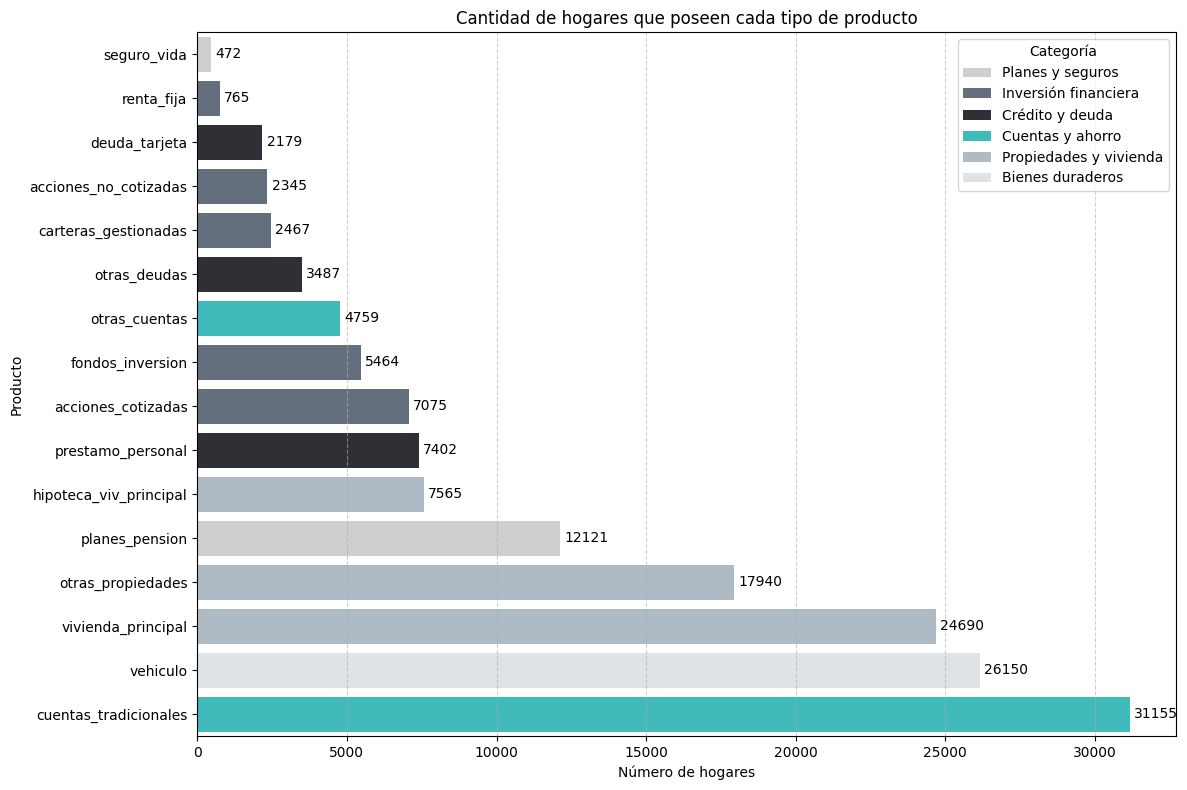

In [33]:
categorias = {
    'Cuentas y ahorro': [
        'posee_cuentas_pago',
        'posee_otras_cuentas'
    ],
    'Inversión financiera': [
        'posee_acciones_cotizadas',
        'posee_acciones_no_cotizadas',
        'posee_fondos_inversion',
        'posee_renta_fija',
        'posee_carteras_gestionadas'
    ],
    'Propiedades y vivienda': [
        'posee_viv_principal',
        'posee_otras_propiedades',
        'posee_hipoteca_viv_principal'
    ],
    'Bienes duraderos': [
        'tiene_vehiculo'
    ],
    'Crédito y deuda': [
        'posee_deuda_tarjeta',
        'posee_prestamo_personal',
        'posee_otras_deudas'
    ],
    'Planes y seguros': [
        'posee_planes_pension',
        'posee_seguro_vida'
    ]
}

# Crear DataFrame con producto, conteo y categoría
datos_productos = []
for i, (categoria, variables) in enumerate(categorias.items()):
    for var in variables:
        cantidad = df_reducido[var].sum()
        datos_productos.append({
            'producto': var,
            'cantidad': cantidad,
            'categoria': categoria
        })

df_plot = pd.DataFrame(datos_productos)

# Diccionario para renombrar los productos a nombres más simples
renombrar_productos = {
    'posee_cuentas_pago': 'cuentas_tradicionales',
    'posee_otras_cuentas': 'otras_cuentas',
    'posee_acciones_cotizadas': 'acciones_cotizadas',
    'posee_acciones_no_cotizadas': 'acciones_no_cotizadas',
    'posee_fondos_inversion': 'fondos_inversion',
    'posee_renta_fija': 'renta_fija',
    'posee_carteras_gestionadas': 'carteras_gestionadas',
    'posee_viv_principal': 'vivienda_principal',
    'posee_otras_propiedades': 'otras_propiedades',
    'posee_hipoteca_viv_principal': 'hipoteca_viv_principal',
    'tiene_vehiculo': 'vehiculo',
    'posee_deuda_tarjeta': 'deuda_tarjeta',
    'posee_prestamo_personal': 'prestamo_personal',
    'posee_otras_deudas': 'otras_deudas',
    'posee_planes_pension': 'planes_pension',
    'posee_seguro_vida': 'seguro_vida'
}
# Aplicar renombramiento a los nombres de producto en df_plot
df_plot['producto'] = df_plot['producto'].replace(renombrar_productos)

# Crear paleta personalizada extendida si hace falta
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36", "#CFCFCF"]

# Asociar un color a cada categoría
categoria_colores = dict(zip(categorias.keys(), custom_palette))

# Crear gráfico con seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_plot.sort_values('cantidad', ascending=True),
    y='producto',
    x='cantidad',
    hue='categoria',
    palette=categoria_colores
)

# Añadir etiquetas al final de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.title("Cantidad de hogares que poseen cada tipo de producto")
plt.xlabel("Número de hogares")
plt.ylabel("Producto")
plt.legend(title="Categoría")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

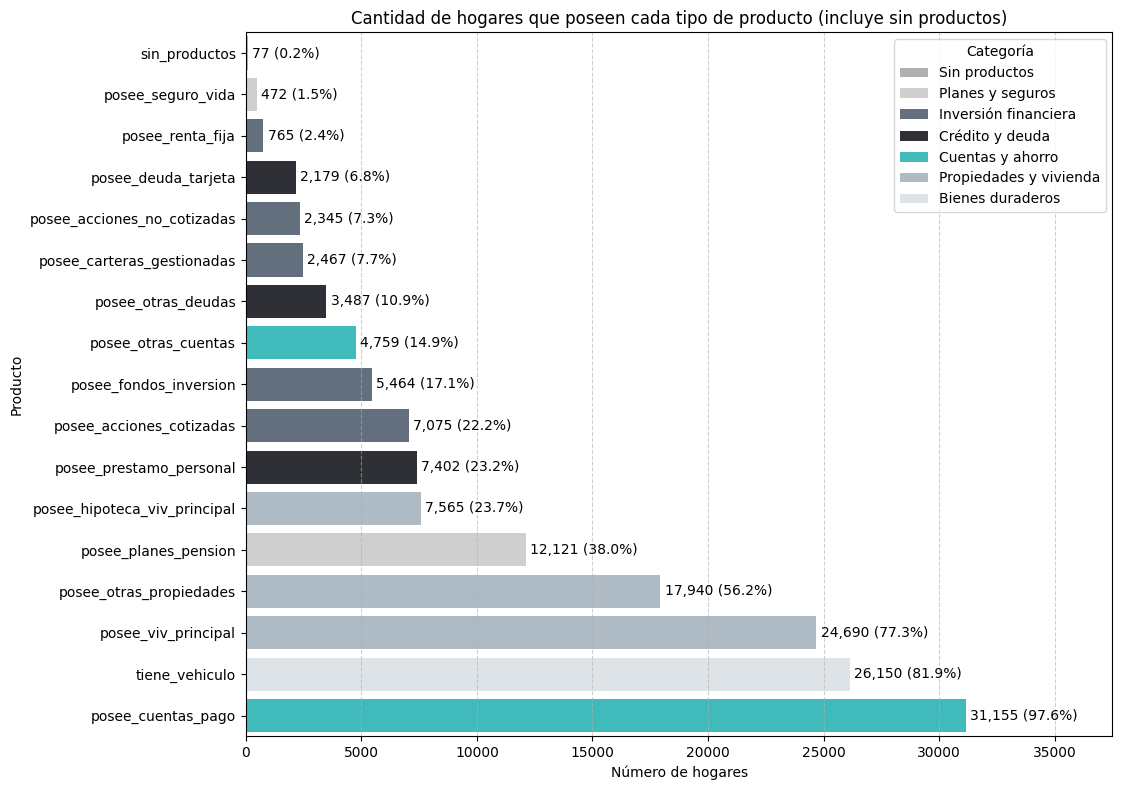

In [34]:
# Añadir categoría "Sin productos" al análisis
# Creamos una columna booleana: True si no tiene ninguno de los productos analizados
productos_binarios = [
    'posee_cuentas_pago', 'posee_otras_cuentas', 'posee_acciones_cotizadas',
    'posee_acciones_no_cotizadas', 'posee_fondos_inversion', 'posee_renta_fija',
    'posee_carteras_gestionadas', 'posee_viv_principal', 'posee_otras_propiedades',
    'posee_hipoteca_viv_principal', 'tiene_vehiculo', 'posee_deuda_tarjeta',
    'posee_prestamo_personal', 'posee_otras_deudas', 'posee_planes_pension', 'posee_seguro_vida'
]

df_reducido['sin_productos'] = (df_reducido[productos_binarios].sum(axis=1) == 0).astype(int)

# Añadir al DataFrame de productos
datos_productos.append({
    'producto': 'sin_productos',
    'cantidad': df_reducido['sin_productos'].sum(),
    'categoria': 'Sin productos'
})

# Actualizar df_plot
df_plot = pd.DataFrame(datos_productos)

# Añadir color para la nueva categoría si quieres en la paleta
categoria_colores['Sin productos'] = "#B0B0B0"

# Gráfico actualizado
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_plot.sort_values('cantidad', ascending=True),
    y='producto',
    x='cantidad',
    hue='categoria',
    palette=categoria_colores
)
total_hogares = len(df_reducido)
for container in ax.containers:
    # container puede tener barras vacías, filtra solo las visibles
    values = [bar.get_width() for bar in container]
    labels = []
    for v in values:
        if v > 0:
            labels.append(f"{int(v):,} ({v/total_hogares:.1%})")
        else:
            labels.append("")
    ax.bar_label(container, labels=labels, label_type='edge', padding=3)

plt.title("Cantidad de hogares que poseen cada tipo de producto (incluye sin productos)")
plt.xlabel("Número de hogares")
plt.ylabel("Producto")
plt.legend(title="Categoría")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, 37500)
plt.show()

In [35]:
saldo_medio_cuentas_pago = int(df_reducido['saldo_cuentas_pago'].mean())
print(f"Saldo medio cuentas de pago: {round(saldo_medio_cuentas_pago / 1000, 1)} k€")
total_hogares = len(df_reducido['id_hogar'])
print("Total hogares en la encuesta: ", total_hogares)

Saldo medio cuentas de pago: 56.3 k€
Total hogares en la encuesta:  31925


In [36]:
df_reducido['saldo_cuentas_pago'].describe()

count    3.188500e+04
mean     5.630315e+04
std      1.629770e+05
min      0.000000e+00
25%      2.000000e+03
50%      1.200000e+04
75%      5.000000e+04
max      4.300000e+06
Name: saldo_cuentas_pago, dtype: float64

### Saldo cuentas y renta neta en función de la edad

In [49]:
print(df_eff['edad_cabeza_hogar'].unique())

# Si los valores originales son tipo string como 'Under 35', '35-44', etc., puedes hacer:
mapa_edades = {
    'Under 35': '18-34',
    '35-44': '35-44',
    '45-54': '45-54',
    '55-64': '55-64',
    '65-74': '65-74',
    'Over 75': '75+'
}

df_eff['edad_cabeza_hogar'] = df_eff['edad_cabeza_hogar'].replace(mapa_edades)

# Ahora puedes comprobar el resultado:
print(df_eff['edad_cabeza_hogar'].unique())

['65-74' '75+' '45-54' '55-64' '35-44' '18-34']
['65-74' '75+' '45-54' '55-64' '35-44' '18-34']


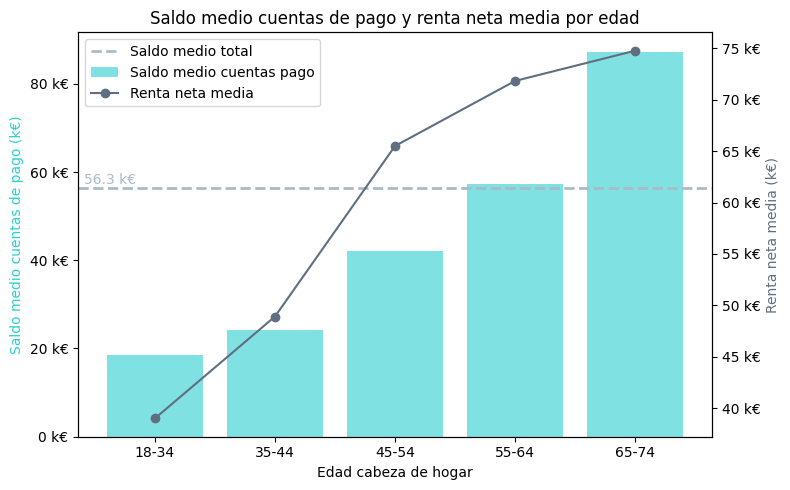

In [75]:
import matplotlib.ticker as mticker

# Agrupa y calcula medias
df_grouped = df_eff.groupby('edad_cabeza_hogar').agg({
    'saldo_cuentas_pago': 'mean',
    'renta_total_hogar': 'mean'
}).loc[['18-34', '35-44', '45-54', '55-64', '65-74']]

# Gráfico de barras comparativo
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = "#2CCED1"
color2 = "#5F6F81"
color_media = "#AABBC8"

# Mostrar valores en miles de euros en los ejes
ax1.bar(df_grouped.index, df_grouped['saldo_cuentas_pago'], color=color1, alpha=0.6, label='Saldo medio cuentas pago')
ax2 = ax1.twinx()
ax2.plot(df_grouped.index, df_grouped['renta_total_hogar'], color=color2, marker='o', label='Renta neta media')

# Línea horizontal del saldo medio total
ax1.axhline(saldo_medio_cuentas_pago, color=color_media, linestyle='--', linewidth=2, label='Saldo medio total')
ax1.text(0.01, saldo_medio_cuentas_pago + 2000, 
    f"{round(saldo_medio_cuentas_pago/1000,1)} k€", 
    color=color_media, va='center', ha='left', fontsize=10, transform=ax1.get_yaxis_transform())

# Formatear los ejes en k€
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f} k€"))
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f} k€"))

ax1.set_ylabel('Saldo medio cuentas de pago (k€)', color=color1)
ax2.set_ylabel('Renta neta media (k€)', color=color2)
ax1.set_xlabel('Edad cabeza de hogar')
ax1.set_title('Saldo medio cuentas de pago y renta neta media por edad')

# Leyenda combinada
lines, labels = [], []
for ax in [ax1, ax2]:
    for line in ax.get_lines() + ax.containers:
        lines.append(line)
        labels.append(line.get_label())
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

# **Situación en nuestra empresa**

In [42]:
df_banca = pd.read_csv("../data/df_250526.csv")
print(df_banca.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26180 entries, 0 to 26179
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  26180 non-null  int64 
 1   id          26180 non-null  int64 
 2   age         26180 non-null  int64 
 3   job         26180 non-null  object
 4   marital     26180 non-null  object
 5   education   26180 non-null  object
 6   default     26180 non-null  bool  
 7   balance     26180 non-null  int64 
 8   housing     26180 non-null  bool  
 9   loan        26180 non-null  bool  
 10  contact     26180 non-null  object
 11  day         26180 non-null  int64 
 12  month       26180 non-null  object
 13  duration    26180 non-null  int64 
 14  campaign    26180 non-null  int64 
 15  pdays       26180 non-null  int64 
 16  previous    26180 non-null  int64 
 17  poutcome    26180 non-null  object
 18  deposit     26180 non-null  bool  
 19  date        26180 non-null  object
dtypes: boo

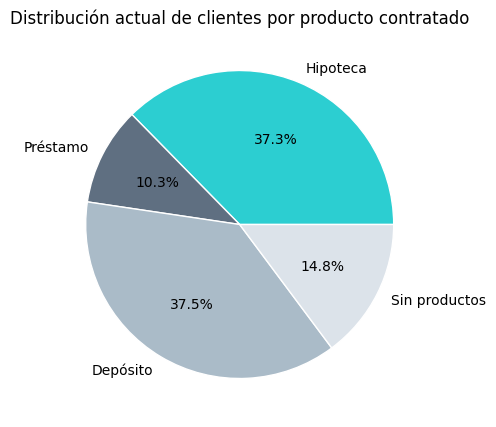

In [44]:
# Pie chart de distribución por productos individuales y sin productos
n_hipoteca = df_banca['housing'].sum()
n_prestamo = df_banca['loan'].sum()
n_deposito = df_banca['deposit'].sum()
n_sin_productos = len(df_banca) - ((df_banca['housing'] | df_banca['loan'] | df_banca['deposit']).sum())

labels = ['Hipoteca', 'Préstamo', 'Depósito', 'Sin productos']
sizes = [n_hipoteca, n_prestamo, n_deposito, n_sin_productos]
colors = custom_palette[:4]

plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title("Distribución actual de clientes por producto contratado")
plt.show()

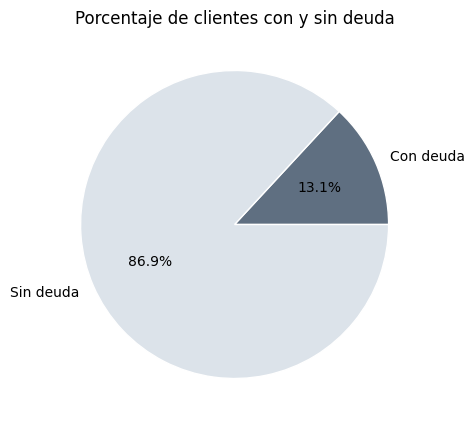

In [45]:
# Pie chart de clientes con deuda y sin deuda
n_con_deuda = df_banca['loan'].sum()
n_sin_deuda = len(df_banca) - n_con_deuda

labels = ['Con deuda', 'Sin deuda']
sizes = [n_con_deuda, n_sin_deuda]
colors = [custom_palette[1], custom_palette[3]]

plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title("Porcentaje de clientes con y sin deuda")
plt.show()